In [1]:
# General imports
import numpy as np
from qiskit import *
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [101]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)

In [77]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
backend = FakeSherbrooke()

In [78]:
backend.name

'fake_sherbrooke'

In [102]:
from qiskit.quantum_info import SparsePauliOp

pauli_list = ['ZIII']

hamiltonian = SparsePauliOp(pauli_list, 1.0)
print(hamiltonian)

#hamiltonian = SparsePauliOp.from_list(
#    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
#)

SparsePauliOp(['ZIII'],
              coeffs=[1.+0.j])


In [103]:
min_eig_exact = min(np.linalg.eigvalsh(hamiltonian))
print(min_eig_exact)

-1.0


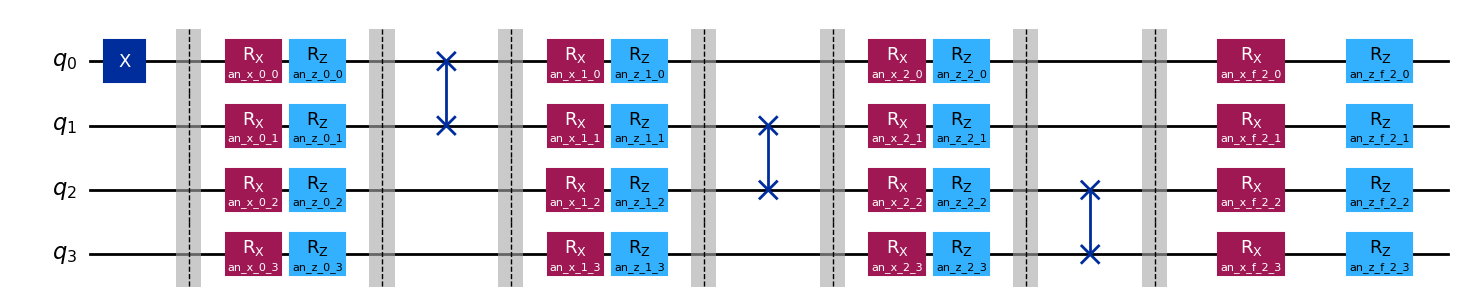

In [104]:
from qiskit.circuit import  Parameter

nqubit=4
qc=QuantumCircuit(nqubit)
c_depth=nqubit-1

qc.x(0)
qc.barrier()
for d in range(c_depth):
    #U_out.add_gate(time_evol_gate)
    
    for i in range(nqubit):
        angle = Parameter(f'an_x_{d}_{i}')#2.0 * np.pi * np.random.rand()
        qc.rx(angle,i)
        angle = Parameter(f'an_z_{d}_{i}')#2.0 * np.pi * np.random.rand()
        qc.rz(angle,i)
    qc.barrier()
    qc.swap(d,d+1)
    qc.barrier()
for i in range(nqubit):
    angle = Parameter(f'an_x_f_{d}_{i}')#2.0 * np.pi * np.random.rand()
    qc.rx(angle,i)
    angle = Parameter(f'an_z_f_{d}_{i}')#2.0 * np.pi * np.random.rand()
    qc.rz(angle,i)    
        
qc.draw("mpl", style="iqp")

In [105]:
num_params = qc.num_parameters
num_params

32

In [106]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(qc)

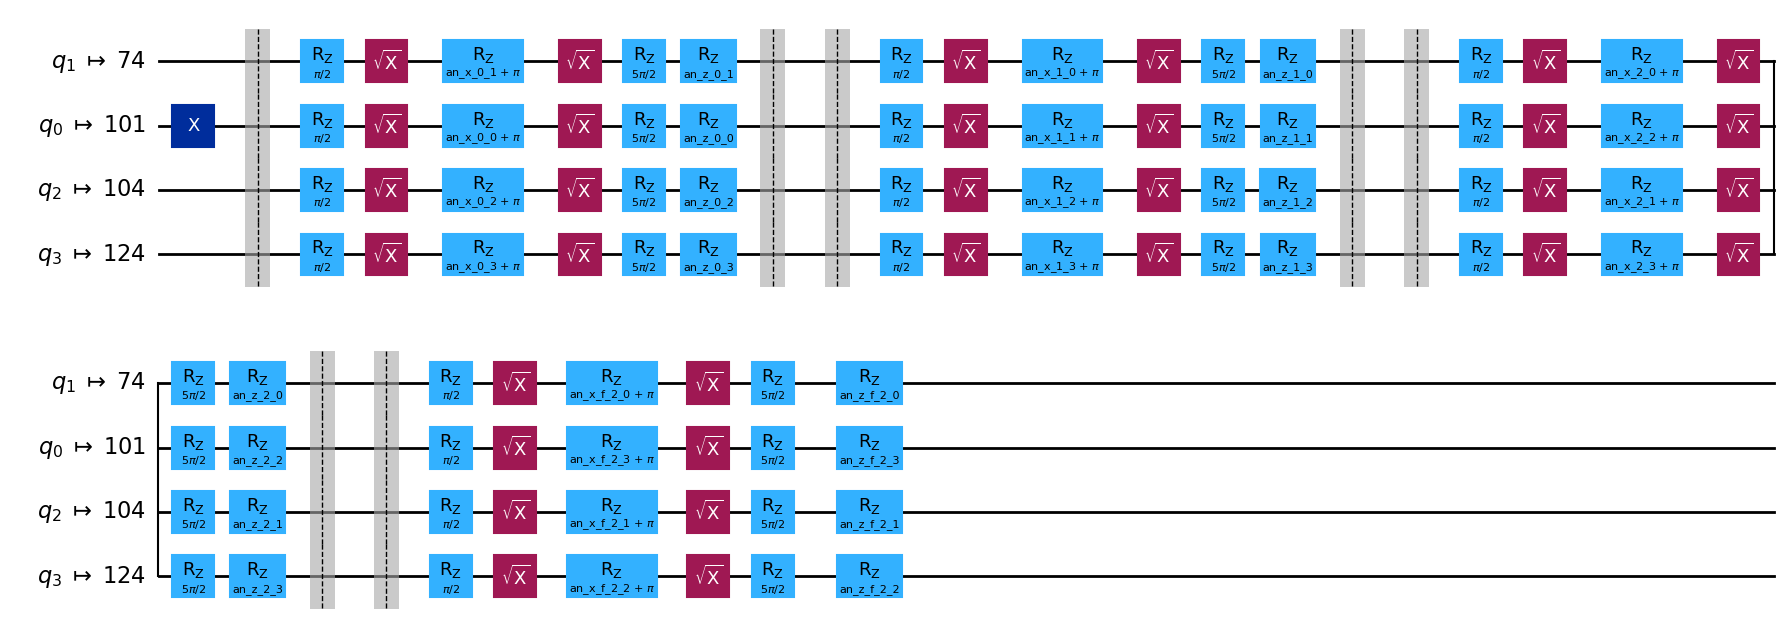

In [107]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [108]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [109]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = 1.0 -result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [110]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [111]:
x0 = 2 * np.pi * np.random.random(num_params)

In [112]:
backend.name

'ibm_sherbrooke'

In [ ]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 400

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla", options={"maxiter": 200}
    )

array([1.02993504, 2.35992235, 6.04199307, 0.90352724, 5.77998088,
       0.80602499, 1.68774826, 5.36144249, 0.89575214, 5.80019744,
       5.44522716, 2.67670219, 1.12791638, 4.75194913, 5.85795226,
       5.20611892, 0.4371057 , 5.00290067, 1.37590851, 3.50168881,
       0.34287926, 2.34283052, 4.73708962, 1.66364937, 5.65350864,
       4.26641483, 0.35838833, 3.7956375 , 0.85646502, 4.81636728,
       4.30433457, 0.48317039])

In [91]:
all(cost_history_dict["prev_vector"] == res.x)
cost_history_dict["iters"] == res.nfev
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.axhline(y=0, color='r', linestyle='--', label="Energía objetivo (-1.84)")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

NameError: name 'res' is not defined